# 决策树
***Author: Neo***
***Date: 2022年2月3日***


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from math import log
import operator

In [2]:
#导入鸢尾花数据集
def createDataSet():
	data=pd.read_csv("./data/DT/Iris.csv")
	del data['Id']
	data=data.values.tolist()
	labels=['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']
	return data,labels

In [3]:
#计算给定数据集的经验熵(香农熵)
def calcShannonEnt(data):
	numEntires = len(data)										#返回数据集的行数
	labelCounts = {}											#保存每个标签(Label)出现次数的字典
	for featVec in data:										#对每组特征向量进行统计
		currentLabel = featVec[-1]								#提取标签(Label)信息
		if currentLabel not in labelCounts.keys():				#如果标签(Label)没有放入统计次数的字典,添加进去
			labelCounts[currentLabel] = 0
		labelCounts[currentLabel] += 1							#Label计数
	shannonEnt = 0.0											#经验熵(香农熵)
	for key in labelCounts:										#计算香农熵
		prob = float(labelCounts[key]) / numEntires				#选择该标签(Label)的概率
		shannonEnt -= prob * log(prob, 2)						#利用公式计算
	return shannonEnt											#返回经验熵(香农熵)

In [4]:
#按照给定特征划分数据集
def splitDataSet(data, axis, value):
	retDataSet = []												#创建返回的数据集列表
	for featVec in data: 										#遍历数据集
		if featVec[axis] == value:
			reducedFeatVec = featVec[:axis]						#去掉axis特征
			reducedFeatVec.extend(featVec[axis+1:]) 			#将符合条件的添加到返回的数据集
			retDataSet.append(reducedFeatVec)
	return retDataSet		  									#返回划分后的数据集

In [5]:
#选择最优特征
def chooseBestFeatureToSplit(data):
	numFeatures = len(data[0]) - 1								#特征数量
	baseEntropy = calcShannonEnt(data) 							#计算数据集的香农熵
	bestInfoGain = 0.0  										#信息增益
	bestFeature = -1											#最优特征的索引值
	for i in range(numFeatures): 								#遍历所有特征
		featList = [example[i] for example in data]				#获取dataSet的第i个所有特征
		uniqueVals = set(featList)     							#创建set集合{},元素不可重复
		newEntropy = 0.0  										#经验条件熵
		for value in uniqueVals: 								#计算信息增益
			subDataSet = splitDataSet(data, i, value) 			#subDataSet划分后的子集
			prob = len(subDataSet) / float(len(data))   		#计算子集的概率
			newEntropy += prob * calcShannonEnt(subDataSet) 	#根据公式计算经验条件熵
		infoGain = baseEntropy - newEntropy 					#信息增益
		# print("第%d个特征的增益为%.3f" % (i, infoGain))			#打印每个特征的信息增益
		if infoGain > bestInfoGain: 							#计算信息增益
			bestInfoGain = infoGain 							#更新信息增益，找到最大的信息增益
			bestFeature = i 									#记录信息增益最大的特征的索引值
	return bestFeature 											#返回信息增益最大的特征的索引值

In [6]:
#统计classList中出现此处最多的元素
def majorityCnt(classList):
	classCount = {}
	for vote in classList:										#统计classList中每个元素出现的次数
		if vote not in classCount.keys():classCount[vote] = 0
		classCount[vote] += 1
	sortedClassCount = sorted(classCount.items(), key = operator.itemgetter(1), reverse = True)		#根据字典的值降序排序
	return sortedClassCount[0][0]								#返回classList中出现次数最多的元素

In [7]:
#创建决策树
def createTree(data, labels, featLabels):
	classList = [example[-1] for example in data]				#取分类标签(是否放贷:yes or no)
	if classList.count(classList[0]) == len(classList):			#如果类别完全相同则停止继续划分
		return classList[0]
	if len(data[0]) == 1 or len(labels) == 0:					#遍历完所有特征时返回出现次数最多的类标签
		return majorityCnt(classList)
	bestFeat = chooseBestFeatureToSplit(data)					#选择最优特征
	bestFeatLabel = labels[bestFeat]							#最优特征的标签
	featLabels.append(bestFeatLabel)
	myTree = {bestFeatLabel:{}}									#根据最优特征的标签生成树
	del(labels[bestFeat])										#删除已经使用特征标签
	featValues = [example[bestFeat] for example in data]		#得到训练集中所有最优特征的属性值
	uniqueVals = set(featValues)								#去掉重复的属性值
	for value in uniqueVals:									#遍历特征，创建决策树。
		subLabels = labels[:]
		myTree[bestFeatLabel][value] = createTree(splitDataSet(data, bestFeat, value), subLabels, featLabels)

	return myTree

In [8]:
#获取决策树叶子结点的数目
def getNumLeafs(myTree):
    numLeafs = 0												#初始化叶子
    firstStr = next(iter(myTree))								#python3中myTree.keys()返回的是dict_keys,不再是list,所以不能使用myTree.keys()[0]的方法获取结点属性，可以使用list(myTree.keys())[0]
    secondDict = myTree[firstStr]								#获取下一组字典
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':				#测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

In [9]:
#获取决策树的层数
def getTreeDepth(myTree):
    maxDepth = 0												#初始化决策树深度
    firstStr = next(iter(myTree))								#python3中myTree.keys()返回的是dict_keys,不在是list,所以不能使用myTree.keys()[0]的方法获取结点属性，可以使用list(myTree.keys())[0]
    secondDict = myTree[firstStr]								#获取下一个字典
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':				#测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth			#更新层数
    return maxDepth

In [10]:
#绘制结点
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
	arrow_args = dict(arrowstyle="<-")							#定义箭头格式
	createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',	#绘制结点
		xytext=centerPt, textcoords='axes fraction',
		va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

In [11]:
#标注有向边属性值
def plotMidText(cntrPt, parentPt, txtString):
	xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]				#计算标注位置
	yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
	createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

In [12]:
#绘制决策树
def plotTree(myTree, parentPt, nodeTxt):
	decisionNode = dict(boxstyle="sawtooth", fc="0.8")			#设置结点格式
	leafNode = dict(boxstyle="round4", fc="0.8")				#设置叶结点格式
	numLeafs = getNumLeafs(myTree)  							#获取决策树叶结点数目，决定了树的宽度
	depth = getTreeDepth(myTree)								#获取决策树层数
	firstStr = next(iter(myTree))								#下个字典
	cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)	#中心位置
	plotMidText(cntrPt, parentPt, nodeTxt)						#标注有向边属性值
	plotNode(firstStr, cntrPt, parentPt, decisionNode)			#绘制结点
	secondDict = myTree[firstStr]								#下一个字典，也就是继续绘制子结点
	plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD			#y偏移
	for key in secondDict.keys():
		if type(secondDict[key]).__name__=='dict':				#测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
			plotTree(secondDict[key],cntrPt,str(key))        	#不是叶结点，递归调用继续绘制
		else:													#如果是叶结点，绘制叶结点，并标注有向边属性值
			plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
			plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
			plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
	plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

In [13]:
#创建绘制面板
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')						#创建fig
    fig.clf()													#清空fig
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops) #去掉x、y轴
    plotTree.totalW = float(getNumLeafs(inTree))				#获取决策树叶结点数目
    plotTree.totalD = float(getTreeDepth(inTree))				#获取决策树层数
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0	#x偏移
    plotTree(inTree, (0.5,1.0), '')								#绘制决策树
    plt.show()													#显示绘制结果

In [14]:
#使用决策树分类
def classify(inputTree, featLabels, testVec):
	firstStr = next(iter(inputTree))							#获取决策树结点
	secondDict = inputTree[firstStr]							#下一个字典
	featIndex = featLabels.index(firstStr)
	for key in secondDict.keys():
		if testVec[featIndex] == key:
			if type(secondDict[key]).__name__ == 'dict':
				classLabel = classify(secondDict[key], featLabels, testVec)
			else: classLabel = secondDict[key]
	return classLabel

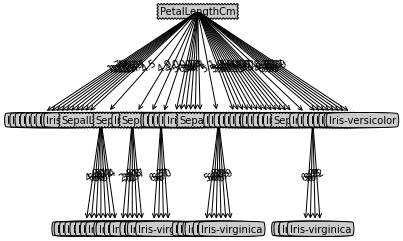

In [15]:
if __name__ == '__main__':
	data, labels = createDataSet()
	featLabels = []
	myTree = createTree(data, labels, featLabels)
	createPlot(myTree)